In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.discrete.count_model as reg_models

In [6]:
# Load all GPCR missense variants
missense_variants = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense.csv',index_col=0)
# Load all GPCR synonymous variants
synonymous_variants = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_synonymous.csv',index_col=0)
# Load all GPCR LoF variants
pLoF_variants = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_plof.csv',index_col=0)
# Load pre-computed constraint metrics
summary_constraint = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_precomputed_constraint.csv',index_col=0)
# Load residue labels for class A GPCRs
residue_labels_classA = pd.read_csv('../data/GPCRdb_residue_numbering/GPCRdb_generic_numbers_by_gpcr_residue_ClassA.csv')
# Load classification of GPCRs
gpcr_classes = pd.read_csv('../data/GuideToPharm_targets/GPCRdb_class_by_gpcr.csv')

In [7]:
# Merge missense variants with class A residue labels and filter for non-matching reference AAs
missense_variants_classA = residue_labels_classA.merge(missense_variants, 
                                                       left_on=['HGNC Symbol','sequence_position'],
                                                       right_on=['HGNC symbol','protein_pos'],
                                                       how='left')
missense_variants_classA = missense_variants_classA.drop([
    'HGNC symbol',
    'ensembl_gene',
    'ensembl_transcript',
    'swissprot_match',
    'protein_pos'
    ],axis=1)
missense_variants_classA = missense_variants_classA[missense_variants_classA['amino_acid']==missense_variants_classA['reference_amino_acid']]
missense_variants_classA.to_csv('../data/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv')

In [8]:
missense_variants_classA = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv',index_col=0)
# Count total synonymous variants per gene
synonymous_counts_by_gene = synonymous_variants[['HGNC symbol']].value_counts().reset_index()
synonymous_counts_by_gene.columns = ['HGNC symbol','obs_synonymous_protein']
# Count total missense variants per gene
missense_counts_by_gene = missense_variants_classA[['HGNC Symbol']].value_counts().reset_index()
missense_counts_by_gene.columns = ['HGNC symbol','obs_missense_protein']
# Count missense variants by segment and protein
missense_counts_by_segment = missense_variants_classA[['HGNC Symbol','protein_segment']].value_counts().reset_index()
missense_counts_by_segment.columns = ['HGNC symbol','protein_segment','obs_missense_segment']
# Count missense variants by structural position and protein
missense_counts_by_position = missense_variants_classA[['HGNC Symbol','GPCRdb_alignment_number']].value_counts().reset_index()
missense_counts_by_position.columns = ['HGNC symbol','GPCRdb_alignment_number','obs_missense_position']
# Count protein lengths
protein_length = residue_labels_classA[['HGNC Symbol']].value_counts().reset_index()
protein_length.columns = ['HGNC symbol','protein_length']
# Count length of segments by protein
segment_length_by_protein = residue_labels_classA[['HGNC Symbol','protein_segment']].value_counts().reset_index()
segment_length_by_protein.columns = ['HGNC symbol','protein_segment','segment_length']
# Presence of structural positions by protein
position_present_by_protein = residue_labels_classA[['HGNC Symbol','GPCRdb_alignment_number']].value_counts().reset_index()
position_present_by_protein.columns = ['HGNC symbol','GPCRdb_alignment_number','position_present']

In [9]:
oe_protein = synonymous_counts_by_gene.merge(missense_counts_by_gene,on='HGNC symbol')
oe_protein['exp_missense_protein'] = 2 * oe_protein['obs_synonymous_protein']
oe_protein['oe_missense_protein'] = oe_protein['obs_missense_protein'] / oe_protein['exp_missense_protein']

In [10]:
oe_segment = (missense_counts_by_segment
                  .merge(synonymous_counts_by_gene,on='HGNC symbol')
                  .merge(segment_length_by_protein,on=['HGNC symbol','protein_segment'])
                  .merge(protein_length,on=['HGNC symbol'])
                  .merge(missense_counts_by_gene,on='HGNC symbol'))
oe_segment['rate_synonymous_protein'] =   oe_segment['obs_synonymous_protein'] / oe_segment['protein_length']
oe_segment['exp_missense_segment'] = (2 * oe_segment['rate_synonymous_protein'] * oe_segment['segment_length'] ) 
oe_segment['oe_missense_segment'] = oe_segment['obs_missense_segment'] / oe_segment['exp_missense_segment']
oe_segment

,HGNC symbol,protein_segment,obs_missense_segment,obs_synonymous_protein,segment_length,protein_length,obs_missense_protein,rate_synonymous_protein,exp_missense_segment,oe_missense_segment
0,LGR5,N-term,312,214,551,907,490,0.235943,260.008820,1.199959
1,LGR5,C-term,29,214,61,907,490,0.235943,28.785006,1.007469
2,LGR5,TM2,28,214,31,907,490,0.235943,14.628445,1.914079
3,LGR5,TM3,19,214,39,907,490,0.235943,18.403528,1.032411
4,LGR5,TM6,17,214,34,907,490,0.235943,16.044101,1.059579
...,...,...,...,...,...,...,...,...,...,...
4297,GPR173,TM7,6,73,26,373,96,0.195710,10.176944,0.589568
4298,GPR173,C-term,5,73,15,373,96,0.195710,5.871314,0.851598
4299,GPR173,H8,5,73,15,373,96,0.195710,5.871314,0.851598
4300,GPR173,ECL1,2,73,7,373,96,0.195710,2.739946,0.729941


In [11]:
oe_position = (position_present_by_protein
                .merge(missense_counts_by_position,on=['HGNC symbol','GPCRdb_alignment_number'],how='left')
                .merge(synonymous_counts_by_gene,on='HGNC symbol')
                .merge(protein_length,on='HGNC symbol'))
oe_position['rate_synonymous_protein'] = oe_position['obs_synonymous_protein'] / oe_position['protein_length']
oe_position['exp_missense_position'] = 2 *oe_position['rate_synonymous_protein']
oe_position['obs_missense_position'] = oe_position['obs_missense_position'].fillna(0)
oe_position['oe_missense_position'] = oe_position['obs_missense_position'] / oe_position['exp_missense_position']
oe_position['segment'] = oe_position['GPCRdb_alignment_number'].str.split(pat='.').apply(lambda x: x[0])
oe_position.to_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_position_constraint.csv')
oe_position

,HGNC symbol,GPCRdb_alignment_number,position_present,obs_missense_position,obs_synonymous_protein,protein_length,rate_synonymous_protein,exp_missense_position,oe_missense_position,segment
0,XCR1,8.61x61,1,0.0,91,333,0.273273,0.546547,0.000000,8
1,XCR1,8.60x60,1,0.0,91,333,0.273273,0.546547,0.000000,8
2,XCR1,3.29x29,1,0.0,91,333,0.273273,0.546547,0.000000,3
3,XCR1,2.63x63,1,2.0,91,333,0.273273,0.546547,3.659341,2
4,XCR1,2.64x64,1,1.0,91,333,0.273273,0.546547,1.829670,2
...,...,...,...,...,...,...,...,...,...,...
73308,MCHR1,2.54x54,1,0.0,146,422,0.345972,0.691943,0.000000,2
73309,MCHR1,2.55x55,1,0.0,146,422,0.345972,0.691943,0.000000,2
73310,MCHR1,2.56x56,1,0.0,146,422,0.345972,0.691943,0.000000,2
73311,MCHR1,2.57x57,1,0.0,146,422,0.345972,0.691943,0.000000,2


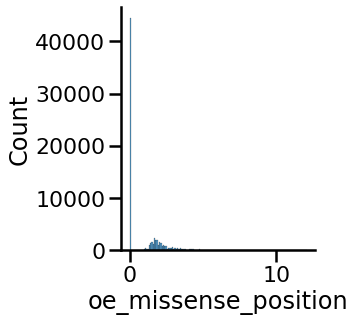

In [10]:
sns.displot(oe_position,x='oe_missense_position')
plt.savefig('../plots/position_constraint_distribution.png')

<AxesSubplot:xlabel='GPCRdb_alignment_number', ylabel='Count'>

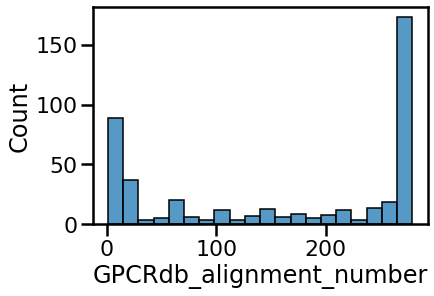

In [12]:
sns.histplot(oe_position.GPCRdb_alignment_number.value_counts(),bins=20)

In [5]:
oe_position = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_position_constraint.csv')
oe_position_average = (oe_position
     .groupby('GPCRdb_alignment_number')
     .agg({'oe_missense_position':[np.mean,np.std,'count']})
     .reset_index())
oe_position_average.columns = [
    'GPCRdb_alignment_number',
    'oe_missense_position_mean',
    'oe_missense_position_std',
    'position_count'
]
oe_position_average['oe_missense_position_sem'] = oe_position_average['oe_missense_position_std'] / oe_position_average['position_count']
oe_position_average['segment'] = oe_position_average['GPCRdb_alignment_number'].apply(lambda x: x[0])
oe_position_average_filter = oe_position_average[
    (oe_position_average['oe_missense_position_sem']<0.1) & \
    (oe_position_average['position_count']>50)
].reset_index()
oe_position_average_filter['segment_type'] = oe_position_average_filter.segment.apply(len).map({1:'TM',2:'Loop'})
oe_position_average_filter.to_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_position_constraint_average_filter.csv')

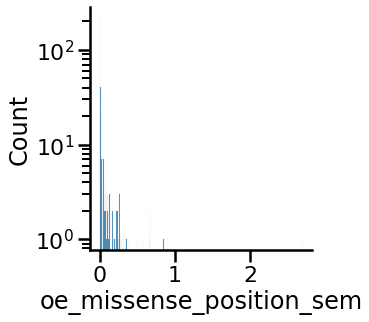

In [13]:
sns.displot(oe_position_average, x='oe_missense_position_sem',kind='hist')
plt.yscale('log')

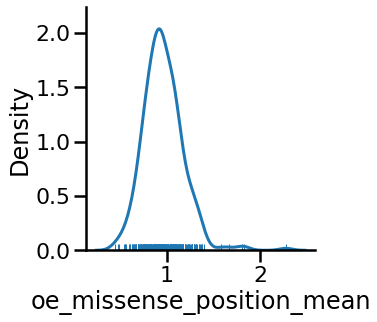

In [15]:
sns.displot(
    oe_position_average_filter,
    x='oe_missense_position_mean',kind='kde',rug=True,
) 
plt.savefig('../plots/average_position_constraint_distribution.png')

In [16]:
oe_position_average_filter['oe_missense_position_mean'].mean()

0.9642772697828991

In [17]:
oe_position_average_filter['oe_missense_position_mean'].std()

0.21586575751783885

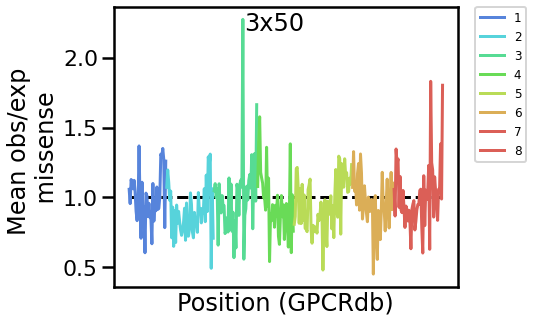

In [51]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,5))
clist = sns.color_palette('hls',n_colors=10)[:7][::-1]
clist.append(clist[-1])
g = sns.lineplot(
    data=oe_position_average_filter,
    x='GPCRdb_alignment_number',
    y='oe_missense_position_mean',
    hue='segment',
    palette=clist,
    ax=ax,
)
plt.annotate('3x50',('3.51x51',2.20))
# plt.fill_between(
#     x = oe_position_average_filter['GPCRdb_alignment_number'],
#     y1 = oe_position_average_filter['oe_missense_position_mean'] + oe_position_average_filter['oe_missense_position_sem'],
#     y2 = oe_position_average_filter['oe_missense_position_mean'] - oe_position_average_filter['oe_missense_position_sem']
# )

plt.hlines(1,'1.27x27','8.63x63',linestyles='dashed',colors='k')
plt.xticks([])
plt.ylabel('Mean obs/exp \n missense ')
plt.xlabel('Position (GPCRdb)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
#g.legend_.remove()
plt.tight_layout()
plt.savefig('../plots/region_constraint/Missense_constraint_by_position_lineplot.png',dpi=500)

In [49]:
sns.color_palette('hls',n_colors=10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

In [47]:
sns.color_palette('husl',n_colors=10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]

In [20]:
highly_unconstrained = oe_position_average_filter.sort_values('oe_missense_position_mean',ascending=False)[:5]
highly_unconstrained

,index,GPCRdb_alignment_number,oe_missense_position_mean,oe_missense_position_std,position_count,oe_missense_position_sem,segment,segment_type
115,166,3.50x50,2.276142,1.998760,279,0.007164,3,TM
305,432,8.51x51,1.831719,1.966559,277,0.007099,8,TM
317,444,8.63x63,1.803637,1.696236,56,0.030290,8,TM
129,180,34.57x57,1.664306,1.950485,216,0.009030,34,Loop
132,188,4.40x40,1.577327,1.765508,269,0.006563,4,TM


In [167]:
oe_dRy = oe_position[oe_position['GPCRdb_alignment_number']=='3.50x50'][['HGNC symbol','oe_missense_position']]
oe_dRy.columns = ['HGNC symbol','oe_missense_dRy']

In [169]:
oe_protein_dRy

,HGNC symbol,obs_synonymous_protein,obs_missense_protein,exp_missense_protein,oe_missense_protein,oe_missense_dRy
0,LGR6,278,504,556,0.906475,0.000000
1,LGR4,216,409,432,0.946759,4.402778
2,LGR5,214,490,428,1.144860,4.238318
3,GPR162,212,338,424,0.797170,1.386792
4,GPR149,199,455,398,1.143216,1.836683
...,...,...,...,...,...,...
274,P2RY10,52,92,104,0.884615,0.000000
275,GPR174,51,106,102,1.039216,3.264706
276,GPR160,51,159,102,1.558824,6.627451
277,LPAR4,51,109,102,1.068627,7.254902


<AxesSubplot:xlabel='oe_missense_protein', ylabel='oe_missense_dRy'>

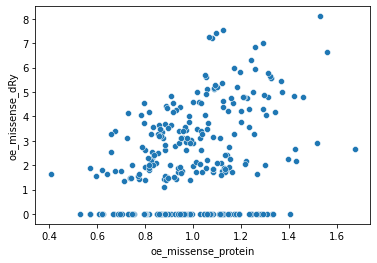

In [170]:
oe_protein_dRy = oe_protein.merge(oe_dRy,on='HGNC symbol')
sns.scatterplot(data=oe_protein_dRy,x='oe_missense_protein',y='oe_missense_dRy')

In [179]:
dRy_allele_counts = missense_variants_classA[
    (missense_variants_classA['GPCRdb_alignment_number']=='3.50x50')
].groupby('HGNC Symbol').agg({'allele_count':sum}).reset_index()

In [194]:
plof_variants = pd.read_csv('../data/gnomad_v2.1.1_gpcr_variants_plof.csv',index_col=0)
plof_allele_counts = plof_variants.groupby('HGNC symbol').agg({'allele_count':sum}).reset_index()

In [195]:
plof_variants.columns

Index(['HGNC symbol', 'HGNC name', 'ensembl_gene', 'ensembl_transcript',
       'ensembl_protein', 'swissprot_match', 'variant_id', 'protein_pos_start',
       'protein_pos_end', 'reference_amino_acid', 'alternate_amino_acid',
       'consequence', 'allele_number', 'allele_count',
       'num_alternate_homozygous'],
      dtype='object')

In [ ]:
plof_dry_allele_counts = plof_allele_counts.merge(dRy_allele_counts,left_on='HGNC symbol',right_on='HGNC Symbol')


In [186]:
missense_variants_classA[
    (missense_variants_classA['GPCRdb_alignment_number']=='3.50x50') & \
    (missense_variants_classA['allele_count'] > 10000)
]

,HGNC Symbol,Uniprot_name,sequence_position,amino_acid,protein_segment,GPCRdb_alignment_number,HGNC name,ensembl_protein,variant_id,reference_amino_acid,alternate_amino_acid,consequence,SIFT,PolyPhen,allele_number,allele_count,num_alternate_homozygous


In [19]:
# Count missense variants by structural position and protein
missense_allele_counts_by_position = (missense_variants_classA
                                .groupby(['HGNC Symbol','GPCRdb_alignment_number'])
                                .agg({'allele_count':sum}).reset_index())
missense_allele_counts_by_position.columns = ['HGNC symbol','GPCRdb_alignment_number','total_allele_count']
missense_allele_counts_by_position = position_present_by_protein.merge(missense_allele_counts_by_position,how='left',on=['HGNC symbol','GPCRdb_alignment_number'])
missense_allele_counts_by_position['total_allele_count'] = missense_allele_counts_by_position['total_allele_count'].fillna(0)
missense_allele_counts_by_position

,HGNC symbol,GPCRdb_alignment_number,position_present,total_allele_count
0,XCR1,8.61x61,1,0.0
1,GPR148,12.50x50,1,0.0
2,GPR148,1.47x47,1,0.0
3,GPR148,1.48x48,1,0.0
4,GPR148,1.49x49,1,9.0
...,...,...,...,...
75363,MCHR1,2.55x55,1,0.0
75364,MCHR1,2.56x56,1,0.0
75365,MCHR1,2.57x57,1,0.0
75366,MCHR1,2.58x58,1,0.0


In [46]:
out=reg_models.ZeroInflatedNegativeBinomialP(y,x,x, inflation='logit')

In [51]:
fit=out.fit(method='bfgs', maxiter = 2000) # May need more than the default 35 iterations, very small number!

Optimization terminated successfully.
         Current function value: 1.370026
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


/home/andrew/miniconda3/envs/variants/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                10000
Model:             ZeroInflatedPoisson   Df Residuals:                     9998
Method:                            MLE   Df Model:                            1
Date:                 Mon, 01 Mar 2021   Pseudo R-squ.:                 0.02953
Time:                         17:18:42   Log-Likelihood:                -13700.
converged:                        True   LL-Null:                       -14117.
Covariance Type:             nonrobust   LLR p-value:                2.535e-183
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inflate_0     -0.3502      0.020    -17.225      0.000      -0.390      -0.310
inflate_1      0.2428      0.020     12.102      0.000       0.203       0.282
0              0.1854      0.007     24.941      0.000       0.171       0.200
1             -0.0885      0.008    -10.734      0.000      -0.105      -0.072
==============================================================================
"""

In [82]:
missense_variants_classA[missense_variants_classA['HGNC Symbol'] == 'CXCR4']

,HGNC Symbol,Uniprot_name,sequence_position,amino_acid,protein_segment,GPCRdb_alignment_number,HGNC name,ensembl_protein,variant_id,reference_amino_acid,alternate_amino_acid,consequence,SIFT,PolyPhen,allele_number,allele_count,num_alternate_homozygous
57400,CXCR4,CXCR4_HUMAN,2,E,N-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs1226785105'],E,G,missense_variant,tolerated_low_confidence(0.29),benign(0.034),248368.0,1.0,0.0
57405,CXCR4,CXCR4_HUMAN,7,Y,N-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs770986091'],Y,C,missense_variant,tolerated_low_confidence(0.17),possibly_damaging(0.645),248298.0,1.0,0.0
57406,CXCR4,CXCR4_HUMAN,7,Y,N-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs560844176'],Y,H,missense_variant,tolerated_low_confidence(0.53),possibly_damaging(0.575),248224.0,1.0,0.0
57409,CXCR4,CXCR4_HUMAN,10,D,N-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs1289282733'],D,V,missense_variant,deleterious(0),benign(0.129),248872.0,2.0,0.0
57410,CXCR4,CXCR4_HUMAN,11,N,N-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs1360006297'],N,S,missense_variant,deleterious(0.03),benign(0.183),248914.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57759,CXCR4,CXCR4_HUMAN,337,H,C-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs752167988'],H,R,missense_variant,tolerated(0.14),unknown(0),247748.0,1.0,0.0
57763,CXCR4,CXCR4_HUMAN,341,S,C-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs148454403'],S,Y,missense_variant,deleterious(0),unknown(0),246584.0,1.0,0.0
57767,CXCR4,CXCR4_HUMAN,345,E,C-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,[],E,G,missense_variant,tolerated_low_confidence(0.41),unknown(0),245350.0,1.0,0.0
57772,CXCR4,CXCR4_HUMAN,350,H,C-term,NaN,C-X-C motif chemokine receptor 4,ENSP00000241393,['rs1299134173'],H,Q,missense_variant,tolerated_low_confidence(0.24),unknown(0),241570.0,1.0,0.0


[]

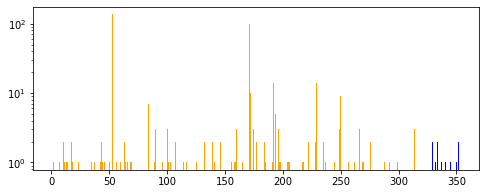

In [100]:
gene_missense_variants = missense_variants_classA[missense_variants_classA['Uniprot_name'] == 'CXCR4_HUMAN'] 
colors = {True:'blue',False:'orange'}
fig, ax1 = plt.subplots(nrows=1,figsize=(8,3))
ax1.bar(
    x=gene_missense_variants['sequence_position'],
    height=gene_missense_variants['allele_count'],
    color=(gene_missense_variants['protein_segment']=='C-term').map(colors)
)
ax1.semilogy()

[]

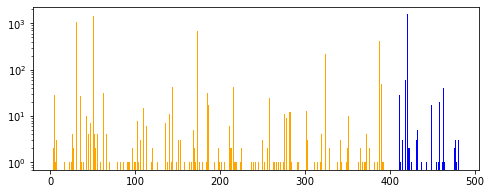

In [112]:
gene_missense_variants = missense_variants_classA[missense_variants_classA['Uniprot_name'] == '5HT2B_HUMAN'] 
colors = {True:'blue',False:'orange'}
fig, ax1 = plt.subplots(nrows=1,figsize=(8,3))
ax1.bar(
    x=gene_missense_variants['sequence_position'],
    height=gene_missense_variants['allele_count'],
    color=(gene_missense_variants['protein_segment']=='C-term').map(colors)
)
ax1.semilogy()

In [45]:
missense_variants['PolyPhen'].str.split('(').apply(lambda x: x[0]).value_counts()

benign               52717
probably_damaging    30891
possibly_damaging    18542
unknown                778
Name: PolyPhen, dtype: int64

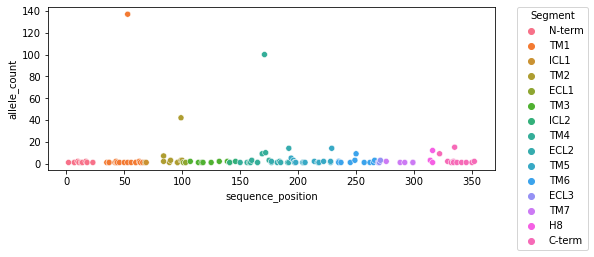

In [96]:
fig, ax1 = plt.subplots(nrows=1,figsize=(8,3))
sns.scatterplot(data=missense_variants_classA[missense_variants_classA['Uniprot_name'] == 'CXCR4_HUMAN'],
           x='sequence_position',y='allele_count',hue='protein_segment',ax=ax1)
#ax1.semilogy()
colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}
plt.legend(title='Segment',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)